# Task 1

Points: 20

You will be working with RGBNet: a network that accepts pixel position as input and outputs a triplet with R, G, B channels of that pixels.
RGBNet is trained on a fixed image. Your tasks are:

1. (14 points) Fill gaps in the code, which creates embeddings in 2 ways:
    - Learned embedding of size 64 (7 points)
    - Positional embedding of size 64 (7 points)


Please note that your code should train within 1 minute and report training loss below 15 for each case.
2. (6 points) Visualize output of the network for each encoding. Does it resemble the input image?

In [21]:
import math
import urllib
from typing import Literal

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

IMG_URL = "https://i.natgeofe.com/k/8fa25ea4-6409-47fb-b3cc-4af8e0dc9616/red-eyed-tree-frog-on-leaves-3-2.jpg"

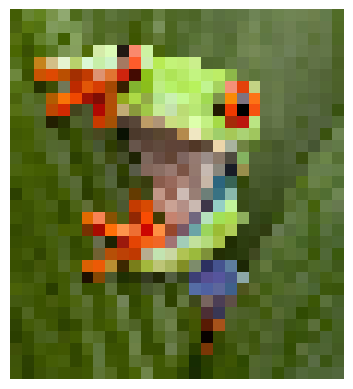

In [22]:
url_response = urllib.request.urlopen(IMG_URL)
img = cv2.imdecode(np.array(bytearray(url_response.read()), dtype=np.uint8), -1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = cv2.resize(img, (0,0), fx=0.01, fy=0.01) 
im_h, im_w = img.shape[0], img.shape[1]

plt.imshow(img)
plt.axis('off')
plt.show()

In [23]:
class NaiveEncoding(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.linear = nn.Linear(2, 64)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self.linear(x.float())
        return self.linear(x.float())


class LearnedEncoding(nn.Module):
    def __init__(self) -> None:
        # Your code goes here. Output dim of embedding should be 64 
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=100, embedding_dim=32)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Your code goes here. Output dim of embedding should be 64 
        x_coord = x[:, 0]
        y_coord = x[:, 1]
        emb_x = self.embedding(x_coord)
        emb_y = self.embedding(y_coord)
        return torch.cat([emb_x, emb_y], dim=1)


class PositionalEncoding(nn.Module):    
    def __init__(self) -> None:
        # Your code goes here. Output dim of embedding should be 64 
        super().__init__()
        self.num_frequencies = 64 // 4
        self.frequencies = torch.pow(2, torch.arange(self.num_frequencies)).float()
        self.register_buffer('freq_bands', self.frequencies)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Your code goes here. Output dim of embedding should be 64 

        x_norm = x.float()/20

        x_proj = x_norm.float().unsqueeze(-1)*self.freq_bands*math.pi
        sin_embed = torch.sin(x_proj)
        cos_embed = torch.cos(x_proj)

        embeddings = torch.cat([sin_embed, cos_embed], dim=1)
        return embeddings.reshape(-1, 64).reshape((x.shape[0], -1))


# Define the network
class RGBNet(nn.Module):
    def __init__(self, encoding_type: Literal["naive", "learned", "positional"]) -> None:
        super().__init__()
        if encoding_type == "naive":
            self.encoding = NaiveEncoding()
        elif encoding_type == "learned":
            self.encoding = LearnedEncoding() 
        elif encoding_type == "positional":
            self.encoding = PositionalEncoding()
        else:
            raise ValueError("Wrong encoding type!")
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 3)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoding(x)
        x = F.softplus(self.fc1(x))
        x = F.softplus(self.fc2(x))
        x = self.fc3(x)
        return x


In [24]:
def train(used_embedding: Literal["naive", "learned", "positional"]) -> torch.nn.Module:
    # Instantiate the model and set it to the GPU (if available)
    model = RGBNet(encoding_type=used_embedding)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define the loss function and optimizer
    criterion = nn.MSELoss(reduction="mean")
    optimizer = optim.AdamW(model.parameters(), lr=0.01)

    # Define the number of epochs and batch size
    num_epochs = 300
    batch_size = 32

    X, y = torch.cartesian_prod(torch.tensor(range(im_w)), torch.tensor(range(im_h))).to(device), torch.flatten(torch.tensor(img, dtype=torch.float32), start_dim=0, end_dim=1).to(device)

    model = model.train()

    # Train the model
    for epoch in range(num_epochs):
        total_loss = 0
        perm = torch.randperm(X.size(0))
        X, y = X[perm,:], y[perm, :]
        for i in range(0, X.shape[0], batch_size):
            # Get the current batch
            X_batch = X[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/X.size(0)}')
    return model

In [25]:
def visualize_model_output(model: RGBNet) -> None:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X = torch.cartesian_prod(torch.tensor(range(im_w)), torch.tensor(range(im_h))).to(device)
    model.eval()
    with(torch.no_grad()):
        output = model(X).reshape(im_h, im_w, 3)
    
    print(output.shape)
    
    img = output.cpu().numpy().astype(np.uint8)


    plt.imshow(img)
    plt.axis('off')
    plt.show()

            


Epoch [1/300], Loss: 122.63380818872407
Epoch [2/300], Loss: 62.706803422919066
Epoch [3/300], Loss: 60.09269816315119
Epoch [4/300], Loss: 62.943896034346196
Epoch [5/300], Loss: 60.53789952713224
Epoch [6/300], Loss: 62.50190545007381
Epoch [7/300], Loss: 58.6876462593606
Epoch [8/300], Loss: 59.8224369172127
Epoch [9/300], Loss: 58.886397401308685
Epoch [10/300], Loss: 60.077960880121324
Epoch [11/300], Loss: 56.97178080334641
Epoch [12/300], Loss: 54.598853326612904
Epoch [13/300], Loss: 52.462361419255835
Epoch [14/300], Loss: 54.05530298470352
Epoch [15/300], Loss: 53.08645573629212
Epoch [16/300], Loss: 55.020208051127774
Epoch [17/300], Loss: 57.59826906265751
Epoch [18/300], Loss: 50.68257387222782
Epoch [19/300], Loss: 49.85767586000504
Epoch [20/300], Loss: 49.75793189826649
Epoch [21/300], Loss: 48.36961962440596
Epoch [22/300], Loss: 49.20083463466662
Epoch [23/300], Loss: 46.3387709938436
Epoch [24/300], Loss: 44.91529501638105
Epoch [25/300], Loss: 44.14581755888627
Epoc

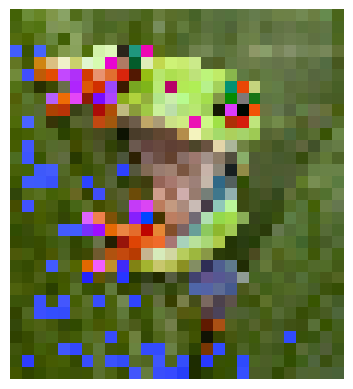

In [26]:
# IMPORTANT: 
# training code works only for 
used_embedding = "naive"
# training and visualization code should work in both
used_embedding = "learned"
used_embedding = "positional"
# used_embedding = "naive"

torch.manual_seed(0)

model = train(used_embedding=used_embedding)
visualize_model_output(model)